For this assignment I am taking a lot of inspirations from this source:

https://www.tensorflow.org/text/tutorials/text_classification_rnn

The Github resository is as follows: 

https://github.com/yiliu7724/disaster-tweet

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pylab as plt 
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
raw_train = pd.read_csv("train.csv")

In [3]:
raw_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
raw_train.target.unique()

array([1, 0], dtype=int64)

In [5]:
target_counts = raw_train.target.value_counts()

In [6]:
target_counts

target
0    4342
1    3271
Name: count, dtype: int64

In [7]:
print(raw_train.dtypes)

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object


Our data have 7613 data points with 3 dimentions actually. 

THe keyword and location dimensions have a very large number of null values according to this simple visualization. And so during data cleaning it would be a good idea to remove them. 

The text is an object in this case. We will need to vectorize this so that it is suitable for feeding into an RNN. 

The target is a binary target. So we can use a sigmoid activation and a single neuron for the output layer. 

There is label imbalance, but this is not severe so accuracy can still work. 

In [8]:
raw_test = pd.read_csv("test.csv")

In [9]:
raw_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


Once again, its probably more efficient to just remove the keyword and location column. here and just do feature extraction from the text column. 

THe id field for the test set will be needed to submit results to kaggle. 

# Data cleaning

In [10]:
train = raw_train.drop(labels=['id','keyword', 'location'], axis = 1)

In [11]:
train

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


In [12]:
train.isna().sum()

text      0
target    0
dtype: int64

Cool, our remaining data does not have any missing values anymore. This is good for text vectorization then. 

In [13]:
test = raw_test.drop(labels=['keyword', 'location'], axis = 1)

In [14]:
test

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,Storm in RI worse than last hurricane. My city...
3260,10868,Green Line derailment in Chicago http://t.co/U...
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...


In [15]:
test.isna().sum()

id      0
text    0
dtype: int64

Looks like our data is suitable now. 

# EDA

Let's first create the vectorizer

In [16]:
vectorizer = keras.layers.TextVectorization(max_tokens=100000,standardize="lower_and_strip_punctuation",split="whitespace",ngrams=None,output_mode="int")

In [17]:
#pd.concat((train.text,raw_test.text), axis = 0)

In [18]:
vectorizer.adapt(pd.concat((train.text,raw_test.text), axis = 0))

In [19]:
vectorizer.get_vocabulary()[:20]

['',
 '[UNK]',
 'the',
 'a',
 'to',
 'in',
 'of',
 'and',
 'i',
 'is',
 'for',
 'on',
 'you',
 'my',
 'it',
 'with',
 'that',
 'by',
 'at',
 'this']

In [20]:
len(vectorizer.get_vocabulary())

29365

Let's visualize what our train set data looks like once we feed into the vectorizer:

In [21]:
vectorizer(train.text)

<tf.Tensor: shape=(7613, 31), dtype=int64, numpy=
array([[ 101, 7977,   21, ...,    0,    0,    0],
       [ 155,   42,  203, ...,    0,    0,    0],
       [  40, 1578, 1552, ...,    0,    0,    0],
       ...,
       [4051, 5811, 6001, ...,    0,    0,    0],
       [  77, 1196,   41, ...,    0,    0,    0],
       [   2,  206,   51, ...,    0,    0,    0]], dtype=int64)>

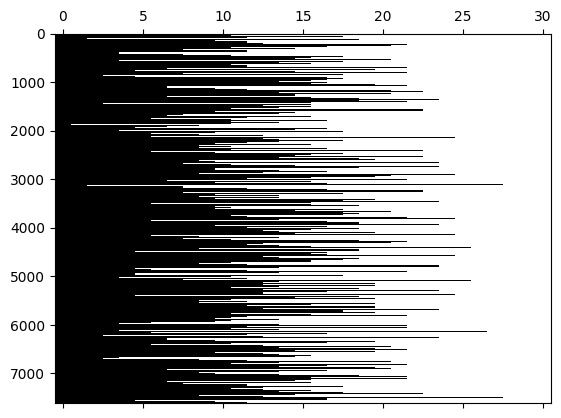

In [22]:
plt.spy(vectorizer(train.text), aspect = 'auto') 

This plot here showed us a rough range of the number of words per tweet. I will also use a histogram to visualize this.

In [23]:
train_text_vectors = vectorizer(train.text)

for this step below i am using a trick suggested by this source:

https://stackoverflow.com/questions/12451954/get-the-number-of-nonzero-elements-in-a-numpy-array

In [24]:
word_count_train = []
for row in train_text_vectors:
    word_count_train.append(np.count_nonzero(row))

(array([ 130.,  486.,  924., 1327., 1320., 1408., 1031.,  664.,  266.,
          57.]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 <BarContainer object of 10 artists>)

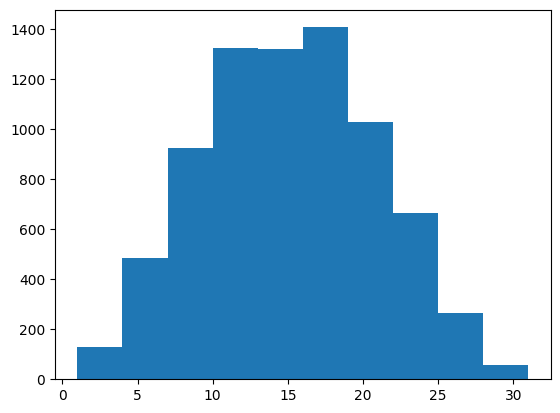

In [25]:
plt.hist(word_count_train) 

The distribution here seems quite symmetrical, not bad. 

Let's try the test set then

In [26]:
test_text_vectors = vectorizer(test.text)

In [27]:
word_count_test = []
for row in test_text_vectors:
    word_count_test.append(np.count_nonzero(row))

(array([ 67., 204., 372., 585., 542., 587., 494., 257., 131.,  24.]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 <BarContainer object of 10 artists>)

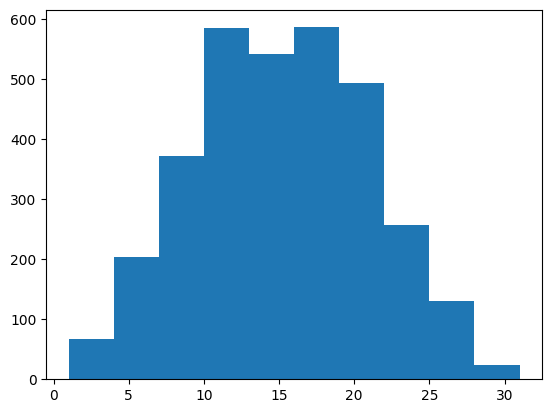

In [28]:
plt.hist(word_count_test) 

Looks like our train and test sets are similar in terms of the number of words per tweet. 

Our number of texts per tweet is relatively small. So we may be able to avoid the vanishing/exploding gradient problem with just the vanilla RNN model with no modifications. 

But regardless I will try other models out. 

Let's do a train validation split then:

In [29]:
x_train, x_vali, y_train, y_vali = train_test_split(train.text, train.target, train_size = 0.8, test_size = 0.2, random_state = 24)

# Model fitting

In [57]:
def makeDFofHist(history):
    model_record = pd.DataFrame([x for x in range(1,len(history.history['accuracy'])+1)], columns=['epoch'])
    model_record = model_record.assign(accuracy=history.history['accuracy'])
    model_record = model_record.assign(F1_score=history.history['F1Score'])
    model_record = model_record.assign(AUC=history.history['auc'])
    model_record = model_record.assign(loss=history.history['loss'])
    model_record = model_record.assign(validation_accuracy=history.history['val_accuracy'])
    model_record = model_record.assign(validation_F1_score=history.history['val_F1Score'])
    model_record = model_record.assign(validation_AUC=history.history['val_auc'])
    model_record = model_record.assign(validation_loss=history.history['val_loss'])
    return model_record

### Vanilla RNN

I will first try the vanilla RNN model:

#### unidirectional

##### Low number of dense layers

In [31]:
simple_RNN_model_less_layers = keras.Sequential([vectorizer, 
                                    keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()), output_dim = 128, mask_zero=True),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.SimpleRNN(128, activation='sigmoid'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.5),
                                    keras.layers.Dense(128, activation='relu'), 
                                    keras.layers.BatchNormalization(), 
                                    keras.layers.Dense(1, activation='sigmoid')])

callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights = True, start_from_epoch= 10)


simple_RNN_model_less_layers.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate = 1e-5),metrics=['accuracy', 'F1Score', 'auc'])

simple_RNN_model_less_layers_history = simple_RNN_model_less_layers.fit(x_train, y_train, epochs = 100, validation_data=(x_vali, y_vali), callbacks=[callback])

Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - F1Score: 0.5895 - accuracy: 0.4965 - auc: 0.4852 - loss: 0.8690 - val_F1Score: 0.5970 - val_accuracy: 0.4255 - val_auc: 0.4832 - val_loss: 0.7085
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - F1Score: 0.6041 - accuracy: 0.5136 - auc: 0.5152 - loss: 0.8349 - val_F1Score: 0.5970 - val_accuracy: 0.4524 - val_auc: 0.5001 - val_loss: 0.7133
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - F1Score: 0.6002 - accuracy: 0.5083 - auc: 0.5095 - loss: 0.8311 - val_F1Score: 0.5970 - val_accuracy: 0.4911 - val_auc: 0.5082 - val_loss: 0.7259
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - F1Score: 0.5997 - accuracy: 0.5268 - auc: 0.5358 - loss: 0.7948 - val_F1Score: 0.5970 - val_accuracy: 0.4911 - val_auc: 0.5093 - val_loss: 0.7510
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - F1Score: 0.5971 - accuracy: 0.5230 - auc: 0.5292 - loss: 0.7943 - val_F1Score: 0.5970 - val_accuracy: 0.5036 - val_auc: 0.5129 - val

In [58]:
simple_RNN_model_less_layers_history_df = makeDFofHist(simple_RNN_model_less_layers_history)

##### Medium number of dense layers

In [34]:
simple_RNN_model_medium_layers = keras.Sequential([vectorizer, 
                                    keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()), output_dim = 128, mask_zero=True),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.SimpleRNN(128, activation='sigmoid'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                    keras.layers.Dense(128, activation='relu'), 
                                    keras.layers.BatchNormalization(), 
                                    keras.layers.Dropout(0.2),
                                    keras.layers.Dense(32, activation='relu'), 
                                    keras.layers.BatchNormalization(), 
                                    keras.layers.Dense(1, activation='sigmoid')])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights = True, start_from_epoch=10)


simple_RNN_model_medium_layers.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate = 1e-5),metrics=['accuracy', 'F1Score', 'auc'])

simple_RNN_model_medium_layers_history = simple_RNN_model_medium_layers.fit(x_train, y_train, epochs = 100, validation_data=(x_vali, y_vali), callbacks=[callback])

Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - F1Score: 0.5944 - accuracy: 0.5219 - auc: 0.5273 - loss: 0.9493 - val_F1Score: 0.5970 - val_accuracy: 0.4294 - val_auc: 0.5159 - val_loss: 0.7110
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - F1Score: 0.5966 - accuracy: 0.5132 - auc: 0.5186 - loss: 0.9534 - val_F1Score: 0.5970 - val_accuracy: 0.4380 - val_auc: 0.5199 - val_loss: 0.7758
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - F1Score: 0.5974 - accuracy: 0.5295 - auc: 0.5339 - loss: 0.9224 - val_F1Score: 0.5970 - val_accuracy: 0.4833 - val_auc: 0.5238 - val_loss: 0.8083
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - F1Score: 0.6011 - accuracy: 0.5233 - auc: 0.5374 - loss: 0.8907 - val_F1Score: 0.5970 - val_accuracy: 0.5200 - val_auc: 0.5274 - val_loss: 0.8299
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - F1Score: 0.5930 - accuracy: 0.5469 - auc: 0.5596 - loss: 0.8626 - val_F1Score: 0.5970 - val_accuracy: 0.5299 - val_auc: 0.5318 - va

In [59]:
simple_RNN_model_medium_layers_history_df = makeDFofHist(simple_RNN_model_medium_layers_history)

##### High number of dense layers

In [36]:
simple_RNN_model_more_layers = keras.Sequential([vectorizer, 
                                    keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()), output_dim = 128, mask_zero=True),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.SimpleRNN(128, activation='sigmoid'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                    keras.layers.Dense(128, activation='relu'), 
                                    keras.layers.BatchNormalization(), 
                                    keras.layers.Dropout(0.2),
                                    keras.layers.Dense(64, activation='relu'), 
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                    keras.layers.Dense(32, activation='relu'), 
                                    keras.layers.BatchNormalization(), 
                                    keras.layers.Dropout(0.2),
                                    keras.layers.Dense(16, activation='relu'), 
                                    keras.layers.BatchNormalization(),              
                                    keras.layers.Dense(1, activation='sigmoid')])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights = True, start_from_epoch=10)


simple_RNN_model_more_layers.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate = 1e-5),metrics=['accuracy', 'F1Score', 'auc'])

simple_RNN_model_more_layers_history = simple_RNN_model_more_layers.fit(x_train, y_train, epochs = 100, validation_data=(x_vali, y_vali), callbacks=[callback])

Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - F1Score: 0.5977 - accuracy: 0.4982 - auc: 0.5031 - loss: 0.9515 - val_F1Score: 0.5970 - val_accuracy: 0.4813 - val_auc: 0.5090 - val_loss: 0.6975
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - F1Score: 0.6031 - accuracy: 0.4960 - auc: 0.4935 - loss: 0.9580 - val_F1Score: 0.5970 - val_accuracy: 0.4826 - val_auc: 0.4958 - val_loss: 0.7343
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - F1Score: 0.6080 - accuracy: 0.5041 - auc: 0.5178 - loss: 0.9101 - val_F1Score: 0.5970 - val_accuracy: 0.4570 - val_auc: 0.4653 - val_loss: 0.8144
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - F1Score: 0.5985 - accuracy: 0.4913 - auc: 0.4917 - loss: 0.9320 - val_F1Score: 0.5970 - val_accuracy: 0.4347 - val_auc: 0.4610 - val_loss: 0.8461
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - F1Score: 0.6089 - accuracy: 0.4964 - auc: 0.5036 - loss: 0.9205 - val_F1Score: 0.5970 - val_accuracy: 0.4478 - val_auc: 0.4647 - val_lo

In [60]:
simple_RNN_model_more_layers_history_df = makeDFofHist(simple_RNN_model_more_layers_history)

#### Bidirectional simple RNN

In [37]:
simple_RNN_model_less_layers_bidirectional = keras.Sequential([vectorizer, 
                                    keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()), output_dim = 128, mask_zero=True),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Bidirectional(keras.layers.SimpleRNN(128, activation='sigmoid')),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.5),
                                    keras.layers.Dense(128, activation='relu'), 
                                    keras.layers.BatchNormalization(), 
                                    keras.layers.Dense(1, activation='sigmoid')])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights = True, start_from_epoch=10)
simple_RNN_model_less_layers_bidirectional.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate = 1e-5),metrics=['accuracy', 'F1Score', 'auc'])

simple_RNN_model_less_layers_bidirectional_history = simple_RNN_model_less_layers_bidirectional.fit(x_train, y_train, epochs = 100, validation_data=(x_vali, y_vali), callbacks=[callback])

Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - F1Score: 0.5985 - accuracy: 0.5021 - auc: 0.5031 - loss: 0.8483 - val_F1Score: 0.5970 - val_accuracy: 0.5739 - val_auc: 0.5276 - val_loss: 0.6816
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - F1Score: 0.6005 - accuracy: 0.5291 - auc: 0.5310 - loss: 0.8210 - val_F1Score: 0.5970 - val_accuracy: 0.5739 - val_auc: 0.5210 - val_loss: 0.6824
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - F1Score: 0.6088 - accuracy: 0.5222 - auc: 0.5335 - loss: 0.8016 - val_F1Score: 0.5970 - val_accuracy: 0.5469 - val_auc: 0.5278 - val_loss: 0.6965
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - F1Score: 0.5970 - accuracy: 0.5430 - auc: 0.5653 - loss: 0.7691 - val_F1Score: 0.5970 - val_accuracy: 0.5358 - val_auc: 0.5388 - val_loss: 0.7172
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - F1Score: 0.5949 - accuracy: 0.5440 - auc: 0.5637 - loss: 0.7653 - val_F1Score: 0.5970 - val_accuracy: 0.5364 - val_auc: 0.5488 - val_

In [61]:
simple_RNN_model_less_layers_bidirectional_history_df = makeDFofHist(simple_RNN_model_less_layers_bidirectional_history)

### LSTM RNN models

#### Unidirectional

In [38]:
LSTM_RNN_model_less_layers = keras.Sequential([vectorizer, 
                                   keras.layers.Embedding(len(vectorizer.get_vocabulary()), output_dim = 128),
                                   keras.layers.BatchNormalization(),
                                   keras.layers.LSTM(128), 
                                   keras.layers.BatchNormalization(), 
                                   keras.layers.Dropout(0.5), 
                                   keras.layers.Dense(128, activation='relu'), 
                                   keras.layers.BatchNormalization(), 
                                   keras.layers.Dense(1, activation='sigmoid')])

LSTM_RNN_model_less_layers.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate = 1e-5),metrics=['accuracy', 'F1Score', 'auc'])

callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights = True, start_from_epoch=10)

LSTM_RNN_model_less_layers_history = LSTM_RNN_model_less_layers.fit(x_train, y_train, epochs = 100, validation_data=(x_vali, y_vali), callbacks=[callback])

Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - F1Score: 0.5992 - accuracy: 0.5055 - auc: 0.5174 - loss: 0.8547 - val_F1Score: 0.5970 - val_accuracy: 0.5745 - val_auc: 0.4999 - val_loss: 0.6829
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - F1Score: 0.6128 - accuracy: 0.5325 - auc: 0.5475 - loss: 0.7902 - val_F1Score: 0.5970 - val_accuracy: 0.5745 - val_auc: 0.4898 - val_loss: 0.6863
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - F1Score: 0.5894 - accuracy: 0.5424 - auc: 0.5592 - loss: 0.7791 - val_F1Score: 0.5970 - val_accuracy: 0.5292 - val_auc: 0.5111 - val_loss: 0.7078
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - F1Score: 0.5940 - accuracy: 0.5422 - auc: 0.5633 - loss: 0.7574 - val_F1Score: 0.5970 - val_accuracy: 0.5456 - val_auc: 0.5327 - val_loss: 0.7150
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - F1Score: 0.6008 - accuracy: 0.5611 - auc: 0.5828 - loss: 0.7458 - val_F1Score: 0.5970 - val_accuracy: 0.5555 - val_auc: 0.5482 - val_los

In [62]:
LSTM_RNN_model_less_layers_history_df = makeDFofHist(LSTM_RNN_model_less_layers_history)

#### Bidirectional

In [39]:
LSTM_RNN_model_less_layers_bidirectional = keras.Sequential([vectorizer, 
                                   keras.layers.Embedding(len(vectorizer.get_vocabulary()), output_dim = 128),
                                   keras.layers.BatchNormalization(),
                                   keras.layers.Bidirectional(keras.layers.LSTM(128)), 
                                   keras.layers.BatchNormalization(), 
                                   keras.layers.Dropout(0.5), 
                                   keras.layers.Dense(128, activation='relu'), 
                                   keras.layers.BatchNormalization(), 
                                   keras.layers.Dense(1, activation='sigmoid')])

LSTM_RNN_model_less_layers_bidirectional.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate = 1e-5),metrics=['accuracy', 'F1Score', 'auc'])

callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights = True, start_from_epoch=10)

LSTM_RNN_model_less_layers_bidirectional_history = LSTM_RNN_model_less_layers_bidirectional.fit(x_train, y_train, epochs = 100, validation_data=(x_vali, y_vali), callbacks=[callback])

Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - F1Score: 0.6038 - accuracy: 0.5112 - auc: 0.5151 - loss: 0.8405 - val_F1Score: 0.5970 - val_accuracy: 0.4294 - val_auc: 0.5452 - val_loss: 0.6987
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - F1Score: 0.6095 - accuracy: 0.5583 - auc: 0.5778 - loss: 0.7760 - val_F1Score: 0.5970 - val_accuracy: 0.5620 - val_auc: 0.5802 - val_loss: 0.6804
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - F1Score: 0.6013 - accuracy: 0.5610 - auc: 0.5854 - loss: 0.7605 - val_F1Score: 0.5970 - val_accuracy: 0.5857 - val_auc: 0.6219 - val_loss: 0.6679
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - F1Score: 0.6027 - accuracy: 0.5846 - auc: 0.6234 - loss: 0.7294 - val_F1Score: 0.5970 - val_accuracy: 0.6165 - val_auc: 0.6527 - val_loss: 0.6675
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - F1Score: 0.5999 - accuracy: 0.6132 - auc: 0.6539 - loss: 0.7010 - val_F1Score: 0.5970 - val_accuracy: 0.6316 - val_auc: 0.6716 - val_los

In [63]:
LSTM_RNN_model_less_layers_bidirectional_history_df = makeDFofHist(LSTM_RNN_model_less_layers_bidirectional_history)

### GRU RNN model

#### Unidirectional

In [40]:
GRU_RNN_model_less_layers = keras.Sequential([vectorizer, 
                                   keras.layers.Embedding(len(vectorizer.get_vocabulary()), output_dim = 128),
                                   keras.layers.BatchNormalization(),
                                   keras.layers.GRU(128), 
                                   keras.layers.BatchNormalization(), 
                                   keras.layers.Dropout(0.5), 
                                   keras.layers.Dense(128, activation='relu'), 
                                   keras.layers.BatchNormalization(), 
                                   keras.layers.Dense(1, activation='sigmoid')])

GRU_RNN_model_less_layers.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate = 1e-5),metrics=['accuracy', 'F1Score', 'auc'])

callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights = True, start_from_epoch=10)

GRU_RNN_model_less_layers_history = GRU_RNN_model_less_layers.fit(x_train, y_train, epochs = 100, validation_data=(x_vali, y_vali), callbacks=[callback])

Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - F1Score: 0.5987 - accuracy: 0.4909 - auc: 0.4910 - loss: 0.8563 - val_F1Score: 0.5970 - val_accuracy: 0.4255 - val_auc: 0.5069 - val_loss: 0.7308
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - F1Score: 0.6038 - accuracy: 0.4862 - auc: 0.4945 - loss: 0.8585 - val_F1Score: 0.5970 - val_accuracy: 0.4301 - val_auc: 0.5144 - val_loss: 0.7400
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - F1Score: 0.5995 - accuracy: 0.5136 - auc: 0.5142 - loss: 0.8064 - val_F1Score: 0.5970 - val_accuracy: 0.4478 - val_auc: 0.5143 - val_loss: 0.7151
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - F1Score: 0.6090 - accuracy: 0.5177 - auc: 0.5279 - loss: 0.7945 - val_F1Score: 0.5970 - val_accuracy: 0.4439 - val_auc: 0.5217 - val_loss: 0.7110
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - F1Score: 0.6047 - accuracy: 0.5133 - auc: 0.5186 - loss: 0.8111 - val_F1Score: 0.5970 - val_accuracy: 0.4951 - val_auc: 0.5151 - val_los

In [64]:
GRU_RNN_model_less_layers_history_df = makeDFofHist(GRU_RNN_model_less_layers_history)

#### Bidirectional

In [41]:
GRU_RNN_model_less_layers_bidirectional = keras.Sequential([vectorizer, 
                                   keras.layers.Embedding(len(vectorizer.get_vocabulary()), output_dim = 128),
                                   keras.layers.BatchNormalization(),
                                   keras.layers.Bidirectional(keras.layers.GRU(128)), 
                                   keras.layers.BatchNormalization(), 
                                   keras.layers.Dropout(0.5), 
                                   keras.layers.Dense(128, activation='relu'), 
                                   keras.layers.BatchNormalization(), 
                                   keras.layers.Dense(1, activation='sigmoid')])

GRU_RNN_model_less_layers_bidirectional.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate = 1e-5),metrics=['accuracy', 'F1Score', 'auc'])

callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights = True, start_from_epoch=10)

GRU_RNN_model_less_layers_bidirectional_history = GRU_RNN_model_less_layers_bidirectional.fit(x_train, y_train, epochs = 100, validation_data=(x_vali, y_vali), callbacks=[callback])

Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - F1Score: 0.6025 - accuracy: 0.5102 - auc: 0.5209 - loss: 0.8508 - val_F1Score: 0.5970 - val_accuracy: 0.4255 - val_auc: 0.5407 - val_loss: 0.7825
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - F1Score: 0.5957 - accuracy: 0.5280 - auc: 0.5500 - loss: 0.8148 - val_F1Score: 0.5970 - val_accuracy: 0.4301 - val_auc: 0.5595 - val_loss: 0.7667
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - F1Score: 0.6046 - accuracy: 0.5468 - auc: 0.5636 - loss: 0.7937 - val_F1Score: 0.5970 - val_accuracy: 0.4662 - val_auc: 0.5803 - val_loss: 0.7687
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - F1Score: 0.6080 - accuracy: 0.5655 - auc: 0.5846 - loss: 0.7701 - val_F1Score: 0.5970 - val_accuracy: 0.5207 - val_auc: 0.6053 - val_loss: 0.7444
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - F1Score: 0.6006 - accuracy: 0.5713 - auc: 0.5987 - loss: 0.7509 - val_F1Score: 0.5970 - val_accuracy: 0.5371 - val_auc: 0.6196 - val_lo

In [65]:
GRU_RNN_model_less_layers_bidirectional_history_df = makeDFofHist(GRU_RNN_model_less_layers_bidirectional_history)

# Model evaluation

In [70]:
def plot_train_and_valid(history):
    epochs = history.epoch

    plt.figure(figsize=(12, 12))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history.loss, label='training', color='green')
    plt.plot(epochs, history.validation_loss, label='validation', color='magenta')
    plt.xlabel('epochs')
    plt.title('loss by epoch')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, history.accuracy, label='training', color='blue')
    plt.plot(epochs, history.validation_accuracy, label='validation', color='orange')
    plt.xlabel('epochs')
    plt.title('accuracy by epoch')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, history.AUC, label='training', color='cyan')
    plt.plot(epochs, history.validation_AUC, label='validation', color='red')
    plt.xlabel('epochs')
    plt.title('AUC by epoch')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, history.F1_score, label='training', color='purple')
    plt.plot(epochs, history.validation_F1_score, label='validation', color='yellow')
    plt.xlabel('epochs')
    plt.title('F1 by epoch')
    plt.legend()

## Vanilla RNN

### unidirectional

#### Low number of dense layers

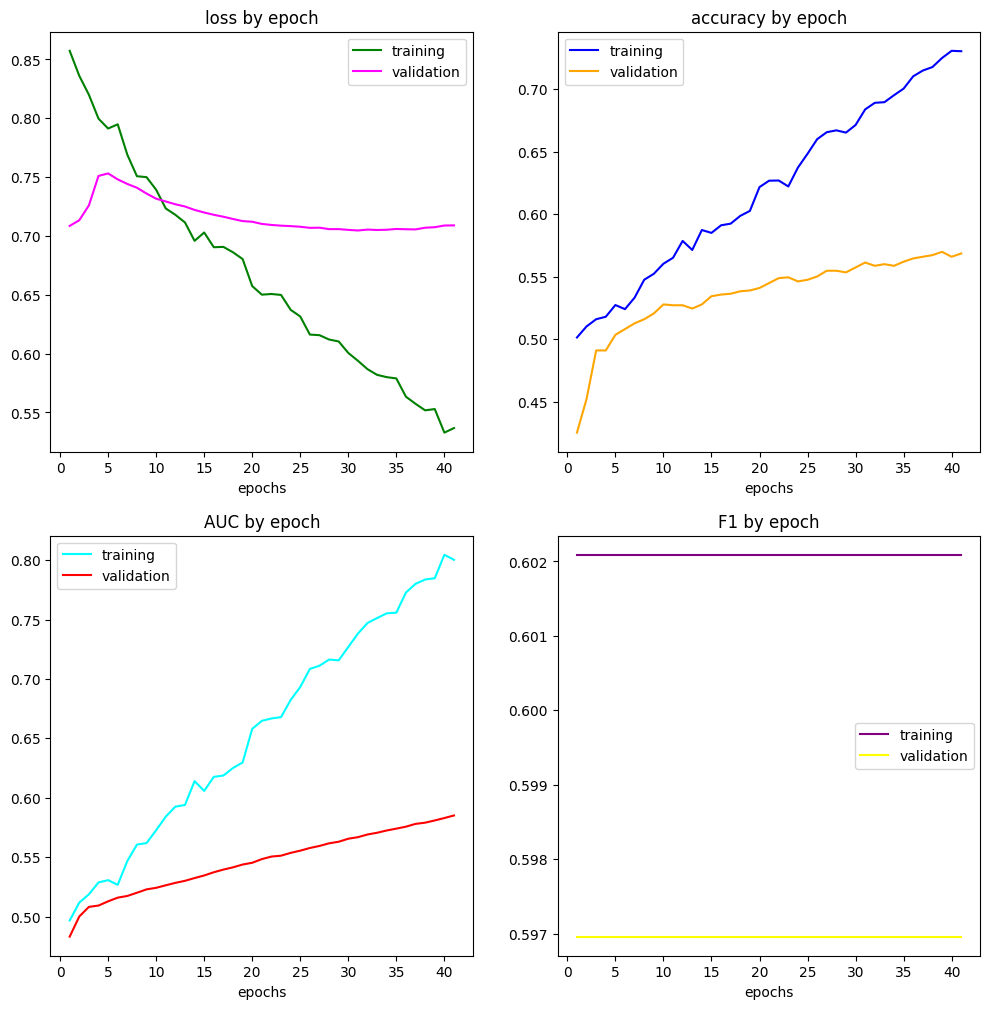

In [71]:
plot_train_and_valid(simple_RNN_model_less_layers_history_df)

#### Medium number of dense layers

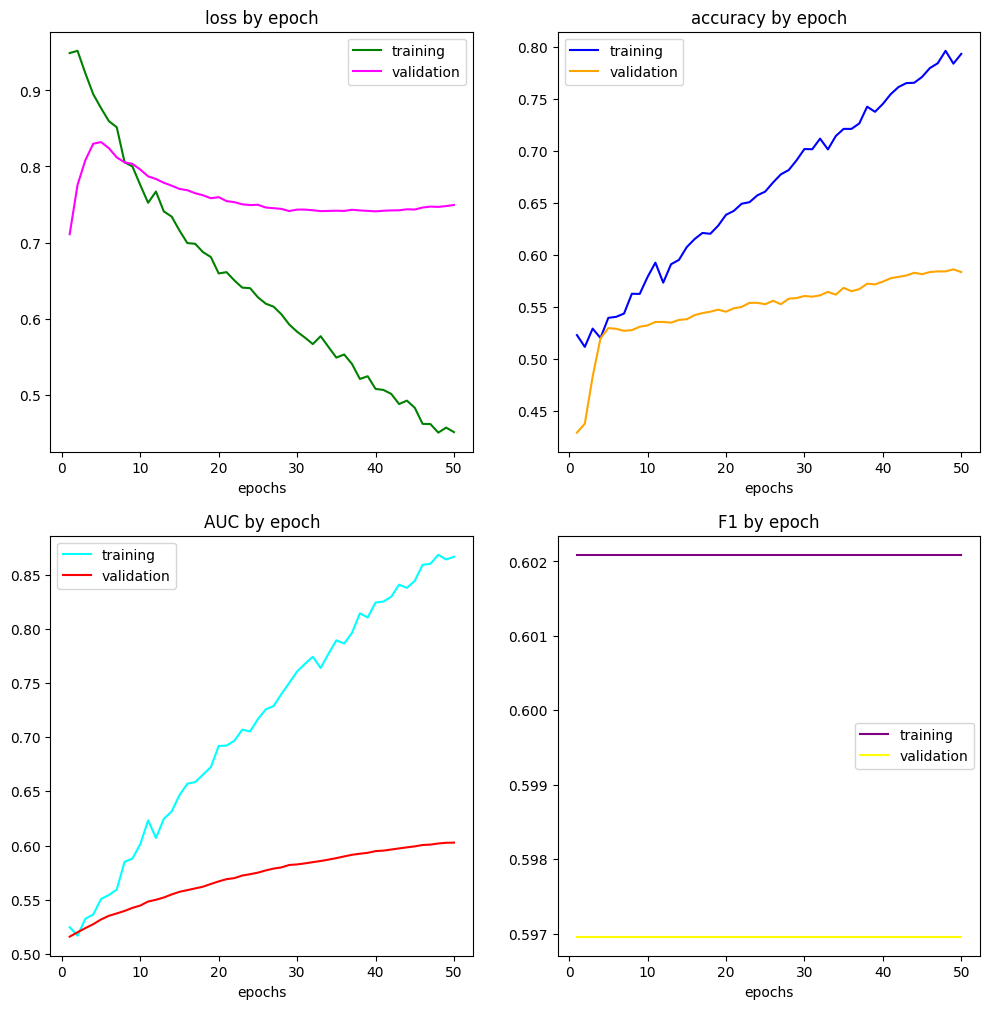

In [72]:
plot_train_and_valid(simple_RNN_model_medium_layers_history_df)

#### High number of dense layers

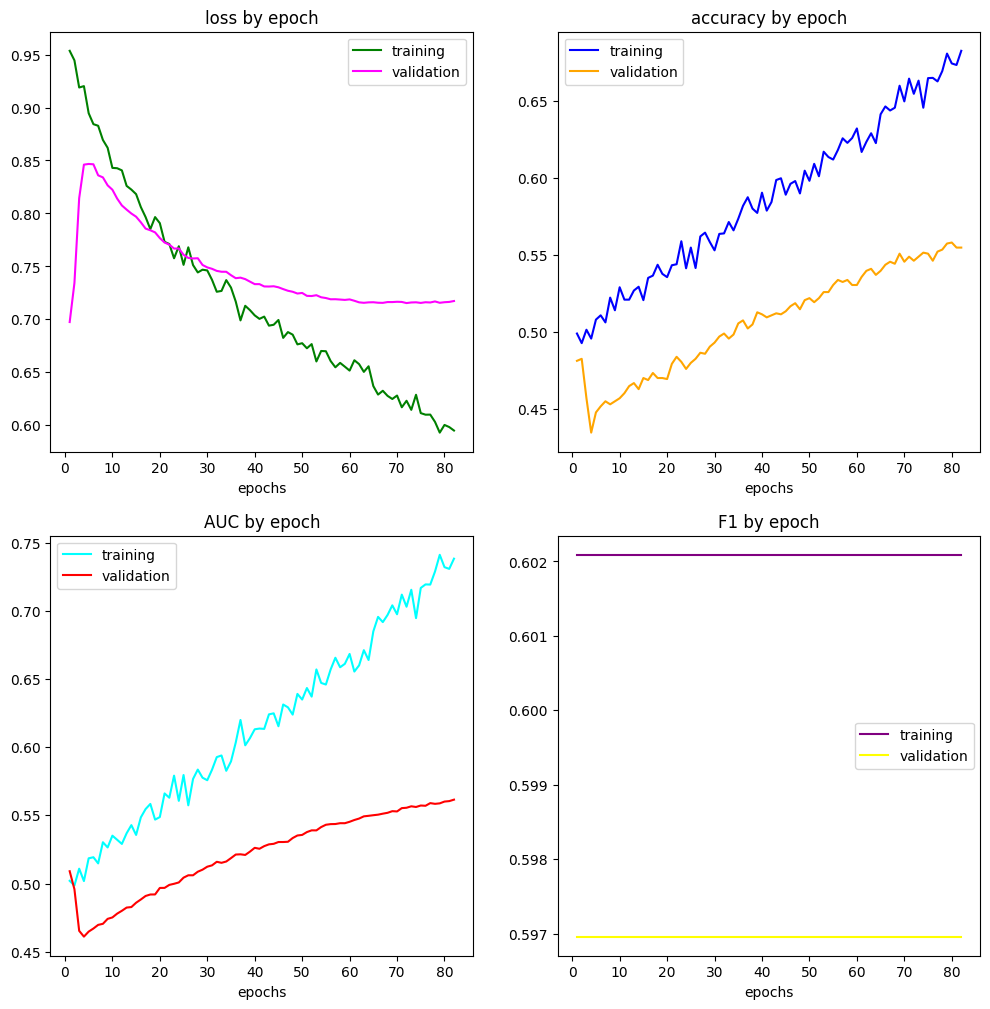

In [74]:
plot_train_and_valid(simple_RNN_model_more_layers_history_df)

### Bidirectional simple RNN

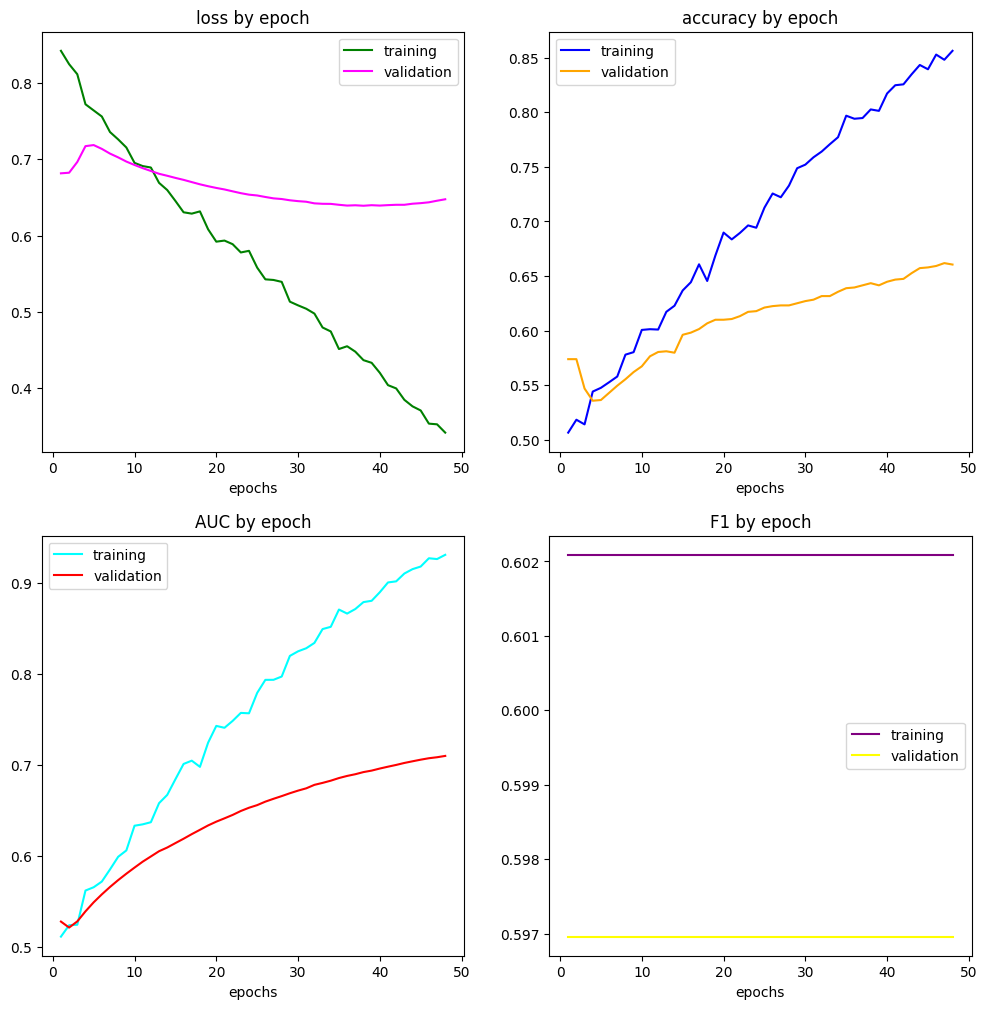

In [76]:
plot_train_and_valid(simple_RNN_model_less_layers_bidirectional_history_df)

## LSTM RNN models

### Unidirectional

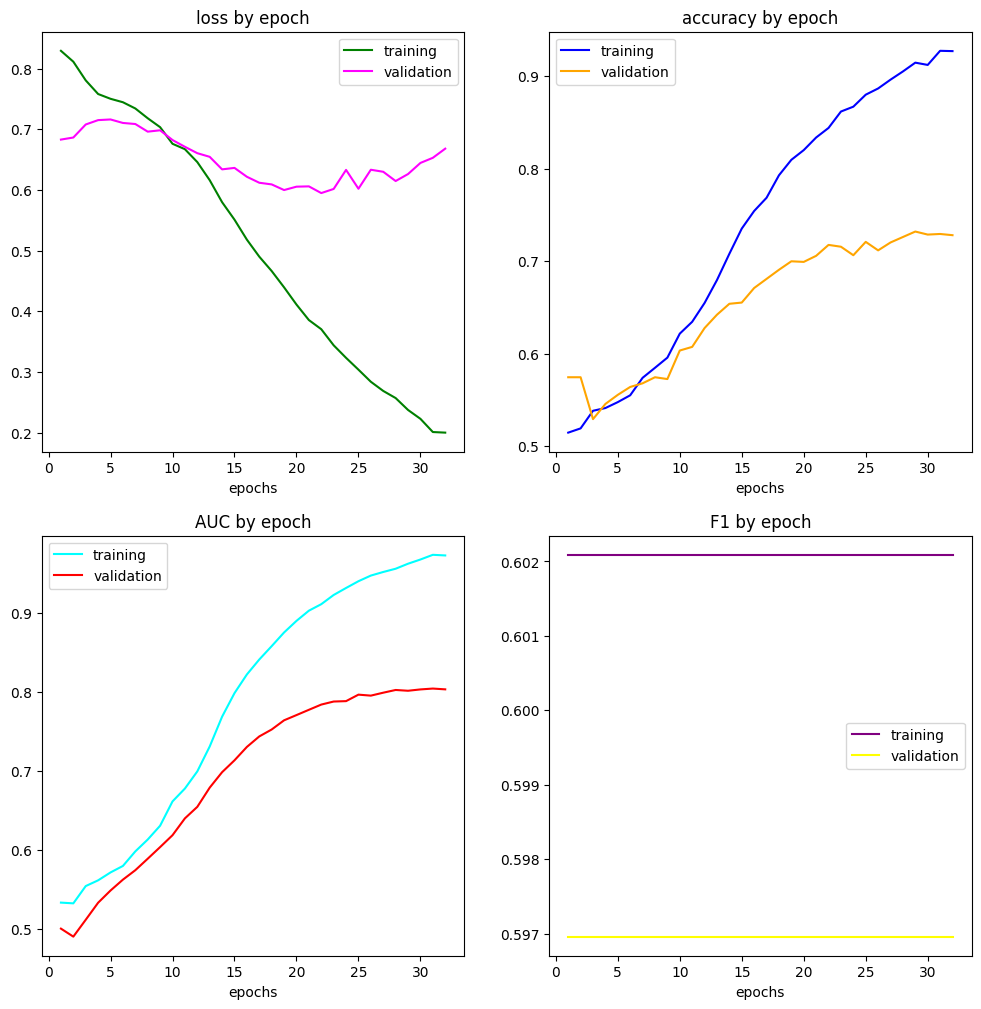

In [78]:
plot_train_and_valid(LSTM_RNN_model_less_layers_history_df)

### Bidirectional

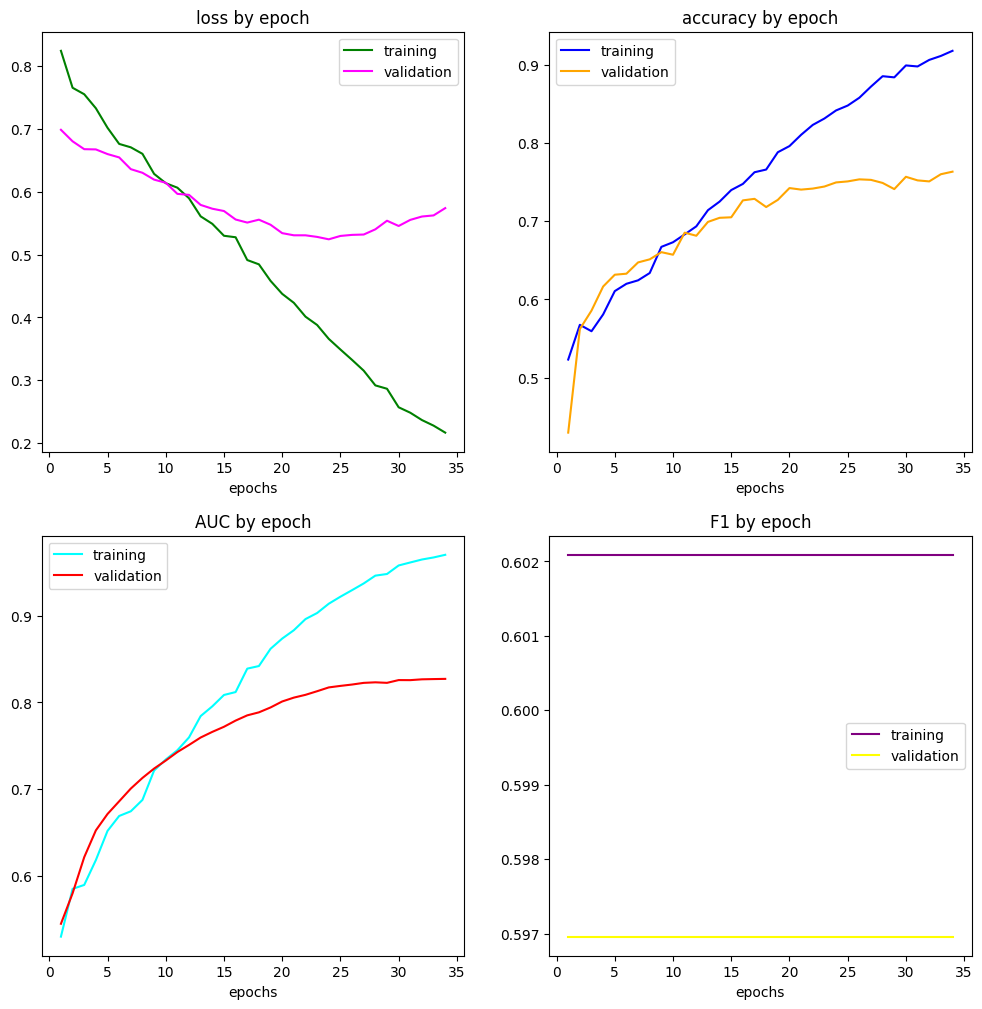

In [79]:
plot_train_and_valid(LSTM_RNN_model_less_layers_bidirectional_history_df)

## GRU RNN model

### Unidirectional

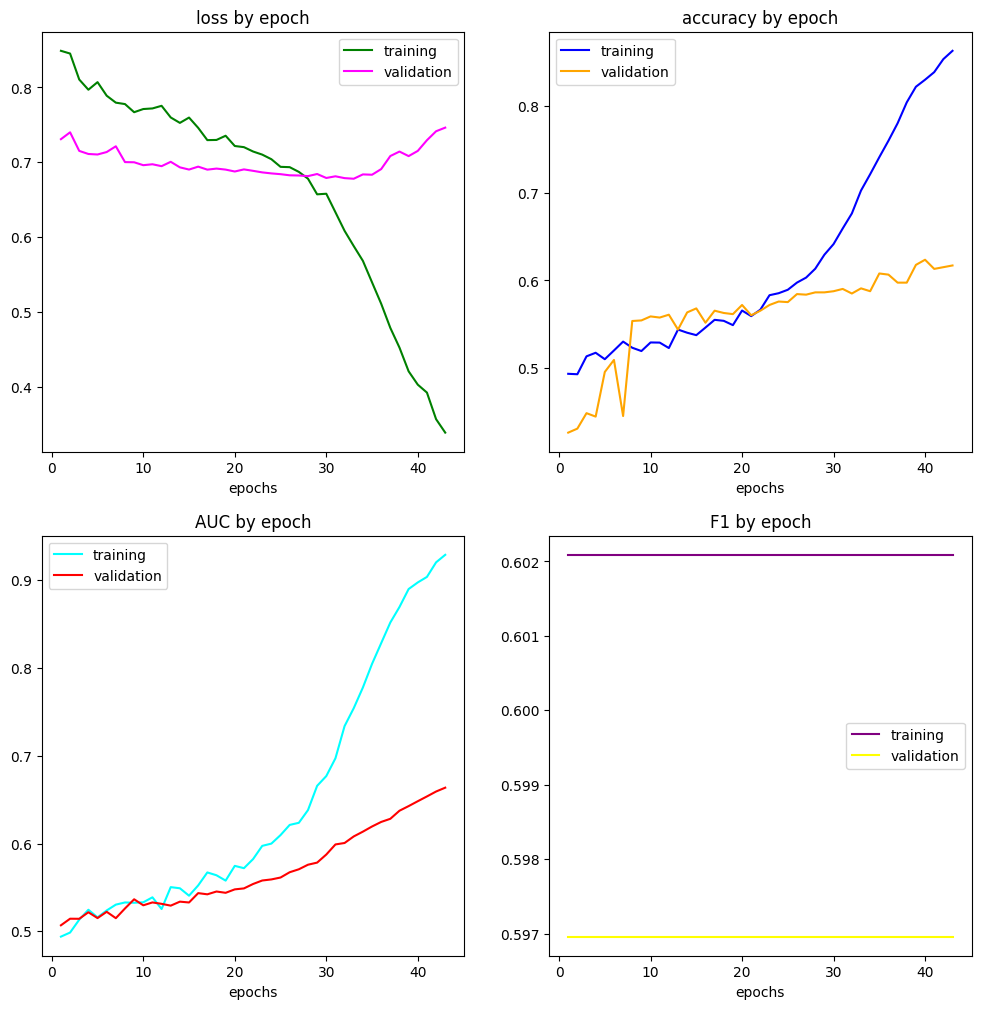

In [80]:
plot_train_and_valid(GRU_RNN_model_less_layers_history_df)

### Bidirectional

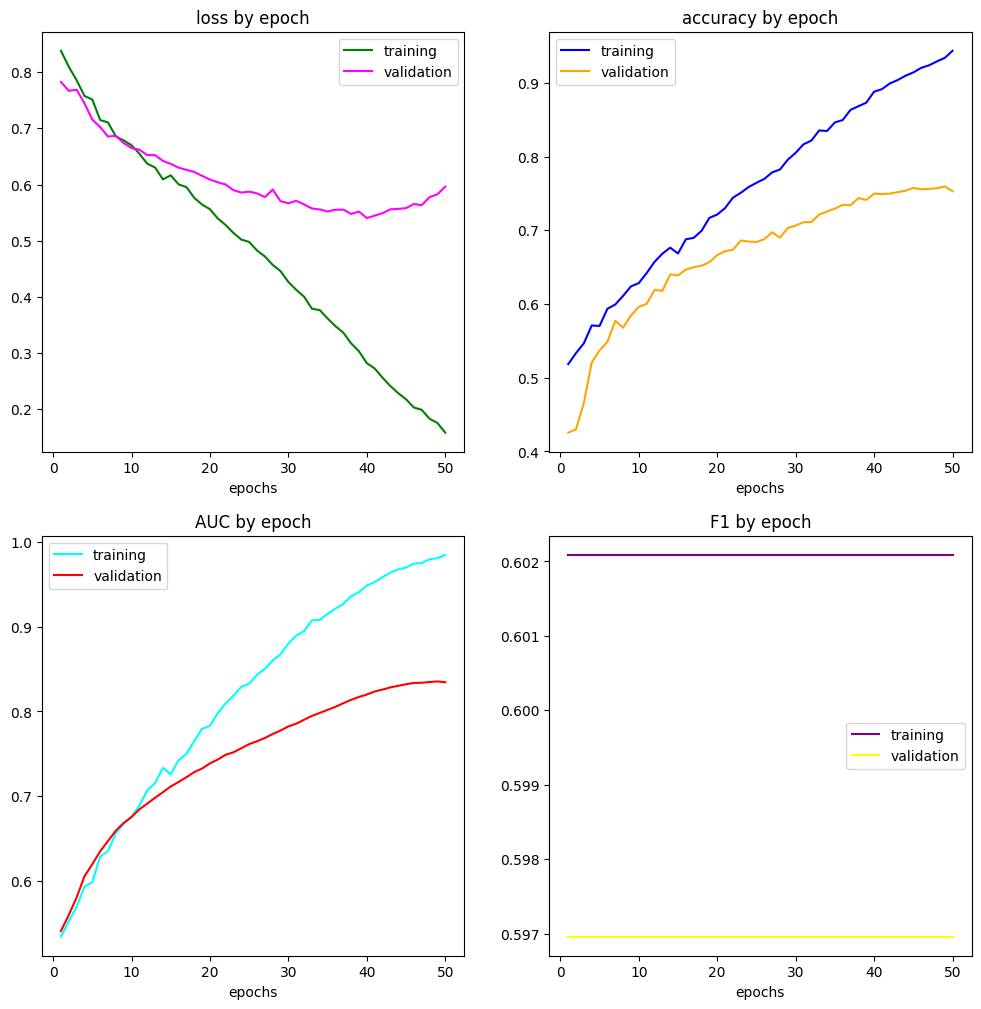

In [81]:
plot_train_and_valid(GRU_RNN_model_less_layers_bidirectional_history_df)

# Discussion and summary

1. The keras f1 score function seems like it might have some problems. I tried the metric on other models in other assignments and got the same problem where the f1 score for the train and validation sets would hardly change. And so I have incorporated other metrics into the plotting to give a better idea on how well the model is training. We can ignore the f1 score plots for these models. 

2. Bidirectionality in the RNN helps model performance in general. Though this is most evident in the GRU model.

3. Model performance increased massively once we switched from the simple RNN to models that allow long term memory like LSTM anf GRU.

4. Using more dense layers do not help.

5. When I ran these models without early stopping the validation accuracy will go up but the validation loss will go up more quickly. This suggest that as the model trains, while it does get more accurate with the validation sets, it also gets more "stubborn" and "insistent" when it is in fact wrong.

6. Continuing on with the previous point, perhaps this is the result of the vectorization procedure but it seems like our decision boundary in this case is quite pourous and so we end up having a limit on how accurate our models can get.

7. The LSTM and GRU models are comprable in their results. The bidirectional GRU model had slightly better AUC at the selected epoch than the bidirectional LSTM model. So i will go with the bidirectional GRU. 

# Creating submission prediction

In [82]:
prediction = GRU_RNN_model_less_layers_bidirectional.predict(test.text)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [84]:
prediction = np.where(prediction > 0.5, 1, 0)

In [90]:
submission = pd.DataFrame(test.id)

In [91]:
submission = submission.assign(target=prediction)

In [93]:
submission.to_csv("submission.csv", index=False)